In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/qa-intents-dataset-university-domain/dataset_test.tsv
/kaggle/input/qa-intents-dataset-university-domain/labels_description.txt
/kaggle/input/qa-intents-dataset-university-domain/dataset_train.tsv


In [2]:
import nltk
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
import torch
from torch import nn
import timeit

In [3]:
import nltk
from nltk.tokenize import word_tokenize
from torch.utils.data import Dataset 
from sklearn.feature_extraction.text import TfidfVectorizer

nltk.download('punkt')

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [4]:
from sklearn.metrics import precision_recall_fscore_support, balanced_accuracy_score
from tqdm import tqdm
import matplotlib.pyplot as plt

In [5]:
train_data = pd.read_csv('../input/qa-intents-dataset-university-domain/dataset_train.tsv',delimiter='\t',encoding="utf-8",names=['text', 'intent'])
test_data = pd.read_csv('../input/qa-intents-dataset-university-domain/dataset_test.tsv',delimiter='\t',encoding="utf-8",names=['text', 'intent'])
train_data.head()

,text,intent
0,мне нужна справка,statement_general
1,оформить справку,statement_general
2,взять справку,statement_general
3,справку как получить,statement_general
4,справку ммф где получаться,statement_general


In [6]:
full_data = pd.concat([train_data, test_data])
full_data.head()

,text,intent
0,мне нужна справка,statement_general
1,оформить справку,statement_general
2,взять справку,statement_general
3,справку как получить,statement_general
4,справку ммф где получаться,statement_general


In [7]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(full_data, test_size=0.2, random_state=42)
unique_values_normalized = train['intent'].value_counts(normalize=True)
print(unique_values_normalized*100)

intent
sched_teacher                8.582817
sched_for_group              3.126661
sched_for_group_day          3.046944
wifi                         2.143490
status_free                  2.037201
                               ...   
loc_nsu_cafeteria            0.168291
location_general             0.168291
student_trade_union_enter    0.159433
staff_trade_union_enter      0.159433
loc_passport_office          0.159433
Name: proportion, Length: 142, dtype: float64


In [8]:
class TextDataset(Dataset):
    def __init__(self, texts, labels):
        self.texts = texts
        self.labels = labels

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        return self.texts[idx], self.labels[idx]

In [9]:
class LSTMClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super().__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = x.unsqueeze(1)  # Добавление дополнительного измерения
#         print(f'x shape: {x.shape}')
        lstm_out, _ = self.lstm(x)
        out = self.fc(lstm_out[:, -1, :])
        return out

In [10]:
# !
from sklearn.preprocessing import LabelEncoder

# Создание LabelEncoder
le = LabelEncoder()

# Подготовка данных
full_data = pd.concat([train_data, test_data])
train, test = train_test_split(full_data, test_size=0.2, random_state=42)

# Преобразование меток в числовые значения
train_labels = le.fit_transform(train['intent'])
test_labels = le.transform(test['intent'])

# # Токенизация и преобразование в TF-IDF
# tokenizer = word_tokenize
# vectorizer = TfidfVectorizer(tokenizer=tokenizer, stop_words='english')

# train_texts = vectorizer.fit_transform(train['text']).toarray()
# test_texts = vectorizer.transform(test['text']).toarray()

# # Преобразование массивов numpy в тензоры PyTorch перед передачей в TextDataset
# train_dataset = TextDataset(torch.from_numpy(train_texts), train_labels)
# test_dataset = TextDataset(torch.from_numpy(test_texts), test_labels)


In [11]:
# Токенизация и преобразование в TF-IDF
tokenizer = word_tokenize
vectorizer = TfidfVectorizer(tokenizer=tokenizer)

train_texts = vectorizer.fit_transform(train['text']).toarray()
test_texts = vectorizer.transform(test['text']).toarray()

# Преобразование массивов numpy в тензоры PyTorch перед передачей в TextDataset
train_dataset = TextDataset(torch.from_numpy(train_texts), train_labels)
test_dataset = TextDataset(torch.from_numpy(test_texts), test_labels)


/opt/conda/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [12]:
# Подготовка данных
# full_data = pd.concat([train_data, test_data])
# train, test = train_test_split(full_data, test_size=0.2, random_state=42)

# le = LabelEncoder()
# train_labels = le.fit_transform(train['intent'])
# test_labels = le.transform(test['intent'])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)


100%|██████████| 89/89 [00:00<00:00, 686.00it/s]


Epoch 1, Train Loss: 3.7665647639768993, Val Loss: 1.973603405309527


100%|██████████| 89/89 [00:00<00:00, 858.18it/s]


Epoch 2, Train Loss: 0.9595557950204898, Val Loss: 0.4233949795532762


100%|██████████| 89/89 [00:00<00:00, 801.67it/s]


Epoch 3, Train Loss: 0.26224718110968304, Val Loss: 0.19555663154198882


100%|██████████| 89/89 [00:00<00:00, 852.40it/s]


Epoch 4, Train Loss: 0.14866173988150133, Val Loss: 0.1512870987814464


100%|██████████| 89/89 [00:00<00:00, 842.10it/s]


Epoch 5, Train Loss: 0.1162836616885223, Val Loss: 0.13435626845137122


100%|██████████| 89/89 [00:00<00:00, 837.13it/s]


Epoch 6, Train Loss: 0.10341786197848386, Val Loss: 0.1324432982665518


100%|██████████| 89/89 [00:00<00:00, 846.87it/s]


Epoch 7, Train Loss: 0.09683686168600539, Val Loss: 0.12225938991779524


100%|██████████| 89/89 [00:00<00:00, 825.04it/s]


Epoch 8, Train Loss: 0.09301265474954995, Val Loss: 0.12177117429987601


100%|██████████| 89/89 [00:00<00:00, 841.46it/s]


Epoch 9, Train Loss: 0.09036362757339081, Val Loss: 0.12436820478754097


100%|██████████| 89/89 [00:00<00:00, 847.34it/s]


Epoch 10, Train Loss: 0.0893351673475063, Val Loss: 0.12267540152749737


100%|██████████| 89/89 [00:00<00:00, 818.62it/s]


Epoch 11, Train Loss: 0.08742667176917712, Val Loss: 0.12091013380938492


100%|██████████| 89/89 [00:00<00:00, 817.14it/s]


Epoch 12, Train Loss: 0.0869483753534894, Val Loss: 0.12172890098809966


100%|██████████| 89/89 [00:00<00:00, 846.66it/s]


Epoch 13, Train Loss: 0.08603619882030934, Val Loss: 0.12542954005701257


100%|██████████| 89/89 [00:00<00:00, 832.92it/s]


Epoch 14, Train Loss: 0.08555046288133665, Val Loss: 0.1255369513927373


100%|██████████| 89/89 [00:00<00:00, 850.37it/s]


Epoch 15, Train Loss: 0.08521143456918673, Val Loss: 0.12431300575831863


100%|██████████| 89/89 [00:00<00:00, 814.80it/s]


Epoch 16, Train Loss: 0.08491796229734473, Val Loss: 0.12656956708145045


100%|██████████| 89/89 [00:00<00:00, 817.30it/s]


Epoch 17, Train Loss: 0.08503687251209995, Val Loss: 0.1303928695642651


100%|██████████| 89/89 [00:00<00:00, 783.25it/s]


Epoch 18, Train Loss: 0.08475765074030582, Val Loss: 0.12886394939765994


100%|██████████| 89/89 [00:00<00:00, 843.31it/s]


Epoch 19, Train Loss: 0.08464397331103636, Val Loss: 0.13273705630445476


100%|██████████| 89/89 [00:00<00:00, 861.74it/s]


Epoch 20, Train Loss: 0.0846444512105256, Val Loss: 0.13337566543650406


100%|██████████| 89/89 [00:00<00:00, 843.04it/s]


Epoch 21, Train Loss: 0.08423650072629975, Val Loss: 0.13075429197087535


100%|██████████| 89/89 [00:00<00:00, 811.79it/s]


Epoch 22, Train Loss: 0.083971148503242, Val Loss: 0.13496042719602014


100%|██████████| 89/89 [00:00<00:00, 825.86it/s]


Epoch 23, Train Loss: 0.08392297394186023, Val Loss: 0.13299891467229397


100%|██████████| 89/89 [00:00<00:00, 861.27it/s]


Epoch 24, Train Loss: 0.0842168856377833, Val Loss: 0.1380878825449768


100%|██████████| 89/89 [00:00<00:00, 848.01it/s]


Epoch 25, Train Loss: 0.08371844821975705, Val Loss: 0.13716608755603782


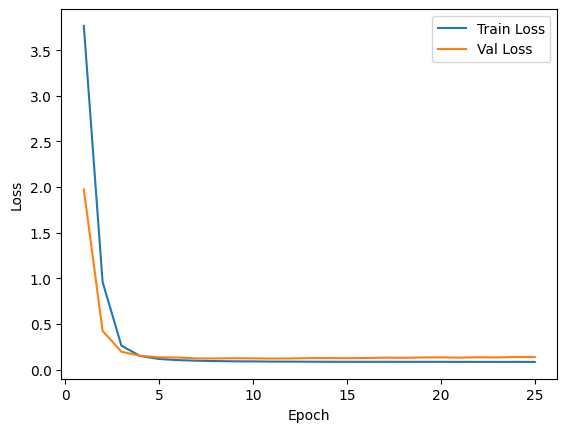

In [13]:
# Создание и обучение модели
model = LSTMClassifier(input_dim=train_texts.shape[1], hidden_dim=256, output_dim=len(le.classes_))

# Перемещение модели на GPU, если он доступен
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

train_losses = []
val_losses = []

n_epoches = 25

for epoch in range(n_epoches):
    train_loss = 0
    val_loss = 0
    # Обучение
    model.train()
    for i, (texts, labels) in enumerate(tqdm(train_loader)):
        # Перемещение данных на тот же устройство, что и модель
        texts = texts.float().to(device)
        labels = labels.to(device)

        outputs = model(texts)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    # Валидация
    model.eval()
    with torch.no_grad():
        for i, (texts, labels) in enumerate(tqdm(test_loader)):
            texts = texts.float().to(device)
            labels = labels.to(device)

            outputs = model(texts)
            loss = criterion(outputs, labels)

            val_loss += loss.item()

    train_loss /= len(train_loader)
    val_loss /= len(test_loader)
    train_losses.append(train_loss)
    val_losses.append(val_loss)

    print(f'Epoch {epoch+1}, Train Loss: {train_loss}, Val Loss: {val_loss}')

# Построение графика потерь
plt.plot(range(1, n_epoches + 1), train_losses, label='Train Loss')
plt.plot(range(1, n_epoches + 1), val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [14]:
# # Прогнозирование на тестовом наборе
# predictions = []
# with torch.no_grad():
#     for i, (input_ids, labels) in enumerate(test_loader):
#         input_ids = input_ids.float().to(device)

#         outputs = model(input_ids)
#         _, predicted = torch.max(outputs.data, 1)
#         predictions.extend(predicted.cpu().numpy())

# # Перевод меток обратно в исходные интенты
# predicted_intents = le.inverse_transform(predictions)

# print(balanced_accuracy_score(test_labels, predictions))
# print(precision_recall_fscore_support(test_labels, predictions, average = 'weighted'))

In [15]:
# Прогнозирование на тестовом наборе
predictions = []
start_test = timeit.default_timer()
with torch.no_grad():
    for i, (input_ids, labels) in enumerate(test_loader):
        input_ids = input_ids.float().to(device)

        outputs = model(input_ids)
        _, predicted = torch.max(outputs.data, 1)
        predictions.extend(predicted.cpu().numpy())
end_test = timeit.default_timer()

# Перевод меток обратно в исходные интенты
predicted_intents = le.inverse_transform(predictions)

# Общее количество предсказанных ответов
num_predictions = len(predictions)

# Среднее время на один ответ
average_time_per_response = (end_test - start_test) / num_predictions

print(f'Time for testing: {end_test - start_test:.4f} seconds')
print(f'Average time per response: {average_time_per_response:.6f} seconds')
print(balanced_accuracy_score(test_labels, predictions))
print(precision_recall_fscore_support(test_labels, predictions, average='weighted'))

Time for testing: 0.1296 seconds
Average time per response: 0.000046 seconds
0.9515149873951123
(0.9488309050728092, 0.9486362026213249, 0.9472236379070113, None)


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [16]:
# Сохранение входных данных, истинных меток и предсказаний в DataFrame
results_df = pd.DataFrame({
    'Input': test['text'],
    'True Label': test['intent'],
    'Predicted Label': predicted_intents
})

# Сохранение DataFrame в CSV файл
results_df.to_csv('model_predictions.csv', index=False)

# Вывод первых нескольких строк для проверки
print(results_df.head())
print(results_df[results_df['True Label']!=results_df['Predicted Label']])

                                                 Input  \
8079              распологается где расписание занятий   
4950                      усваивать семинарист сколько   
9941                            где есть экзамен число   
600   как мне заказать разрешение на внос оборудования   
1121                               где есть деканат эф   

                   True Label          Predicted Label  
8079           sched_location           sched_location  
4950   stat_numb_of_academics   stat_numb_of_academics  
9941               sched_exam               sched_exam  
600   student_union_equipment  student_union_equipment  
1121              loc_dean_ef              loc_dean_ef  
                                                  Input  \
2342                   институт электрометрии раскопать   
2662                      пройти институт электрометрии   
2444              расположен где институт электрометрии   
2495                  институт электрометрии обнаружить   
7720          

mini-LM

In [17]:
import torch
from transformers import AutoTokenizer, AutoModel
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support, balanced_accuracy_score

In [18]:
import pandas as pd
import torch
from torch.utils.data import DataLoader, Dataset, random_split
from transformers import AutoTokenizer, AutoModel
from sklearn.preprocessing import LabelEncoder
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from tqdm import tqdm

In [19]:
# Создание пользовательского Dataset класса
class TextDataset(Dataset):
    def __init__(self, embeddings, labels):
        self.embeddings = embeddings
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.embeddings[idx], self.labels[idx]


In [20]:
# Определение модели LSTM
class LSTMClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(LSTMClassifier, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        _, (hn, _) = self.lstm(x.unsqueeze(1))
        out = self.fc(hn[-1])
        return out

In [21]:
# Load tokenizer and model
tokenizer = AutoTokenizer.from_pretrained("sentence-transformers/all-MiniLM-L6-v2")
model = AutoModel.from_pretrained("sentence-transformers/all-MiniLM-L6-v2")

# Load your dataset
train_data = pd.read_csv('../input/qa-intents-dataset-university-domain/dataset_train.tsv', delimiter='\t', encoding="utf-8", names=['text', 'intent'])
test_data = pd.read_csv('../input/qa-intents-dataset-university-domain/dataset_test.tsv', delimiter='\t', encoding="utf-8", names=['text', 'intent'])
full_data = pd.concat([train_data, test_data])

# Split the data into train and test sets
train, test = train_test_split(full_data, test_size=0.2, random_state=42)

# Tokenize and encode the text data
train_encodings = tokenizer(train['text'].tolist(), truncation=True, padding=True, return_tensors="pt")
test_encodings = tokenizer(test['text'].tolist(), truncation=True, padding=True, return_tensors="pt")

# Extract embeddings
with torch.no_grad():
    train_embeddings = model(**train_encodings).pooler_output
    test_embeddings = model(**test_encodings).pooler_output

le = LabelEncoder()

# Преобразование меток в числовые значения
train_labels = le.fit_transform(train['intent'])
test_labels = le.transform(test['intent'])


# Преобразование массивов numpy в тензоры PyTorch перед передачей в TextDataset
train_dataset = TextDataset(train_embeddings, torch.tensor(train_labels))
test_dataset = TextDataset(test_embeddings, torch.tensor(test_labels))

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)


tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

100%|██████████| 89/89 [00:00<00:00, 1187.83it/s]


Epoch 1, Train Loss: 3.875215438540191, Val Loss: 2.702949594915583


100%|██████████| 89/89 [00:00<00:00, 1290.49it/s]


Epoch 2, Train Loss: 2.003962822406218, Val Loss: 1.570971343624458


100%|██████████| 89/89 [00:00<00:00, 1298.95it/s]


Epoch 3, Train Loss: 1.2500625684984008, Val Loss: 1.1009527953822962


100%|██████████| 89/89 [00:00<00:00, 1327.90it/s]


Epoch 4, Train Loss: 0.8949501254403219, Val Loss: 0.8500848687096928


100%|██████████| 89/89 [00:00<00:00, 1333.22it/s]


Epoch 5, Train Loss: 0.6952969775490315, Val Loss: 0.7022640199473734


100%|██████████| 89/89 [00:00<00:00, 1304.18it/s]


Epoch 6, Train Loss: 0.5639669685796029, Val Loss: 0.5942359720723013


100%|██████████| 89/89 [00:00<00:00, 1219.76it/s]


Epoch 7, Train Loss: 0.47359565955721283, Val Loss: 0.5165957445174121


100%|██████████| 89/89 [00:00<00:00, 1301.32it/s]


Epoch 8, Train Loss: 0.40726366461843, Val Loss: 0.4593407270613681


100%|██████████| 89/89 [00:00<00:00, 1303.15it/s]


Epoch 9, Train Loss: 0.3578127192876832, Val Loss: 0.412853127282657


100%|██████████| 89/89 [00:00<00:00, 1327.12it/s]


Epoch 10, Train Loss: 0.3163281858136228, Val Loss: 0.3799003083886725


100%|██████████| 89/89 [00:00<00:00, 1335.70it/s]


Epoch 11, Train Loss: 0.28611173016407, Val Loss: 0.34651202549425403


100%|██████████| 89/89 [00:00<00:00, 1307.58it/s]


Epoch 12, Train Loss: 0.2589954773739782, Val Loss: 0.32158123844125297


100%|██████████| 89/89 [00:00<00:00, 1294.81it/s]


Epoch 13, Train Loss: 0.23804232868611305, Val Loss: 0.3091192599176691


100%|██████████| 89/89 [00:00<00:00, 1326.83it/s]


Epoch 14, Train Loss: 0.2201016944524418, Val Loss: 0.28764021430122716


100%|██████████| 89/89 [00:00<00:00, 1307.76it/s]


Epoch 15, Train Loss: 0.20398523383074713, Val Loss: 0.2754545822069886


100%|██████████| 89/89 [00:00<00:00, 1301.36it/s]


Epoch 16, Train Loss: 0.1917932942594077, Val Loss: 0.25927009847894145


100%|██████████| 89/89 [00:00<00:00, 1321.05it/s]


Epoch 17, Train Loss: 0.18014428427933635, Val Loss: 0.2510557033623872


100%|██████████| 89/89 [00:00<00:00, 1323.07it/s]


Epoch 18, Train Loss: 0.16907818876101344, Val Loss: 0.24511435565151526


100%|██████████| 89/89 [00:00<00:00, 1218.12it/s]


Epoch 19, Train Loss: 0.16114942626579118, Val Loss: 0.23595557962491942


100%|██████████| 89/89 [00:00<00:00, 1276.90it/s]


Epoch 20, Train Loss: 0.1537875270328508, Val Loss: 0.2296898082066118


100%|██████████| 89/89 [00:00<00:00, 1291.07it/s]


Epoch 21, Train Loss: 0.14587133878013567, Val Loss: 0.22346865670399718


100%|██████████| 89/89 [00:00<00:00, 1341.30it/s]


Epoch 22, Train Loss: 0.14109493776754853, Val Loss: 0.218428444514951


100%|██████████| 89/89 [00:00<00:00, 1280.35it/s]


Epoch 23, Train Loss: 0.13507817254504637, Val Loss: 0.21392155229375603


100%|██████████| 89/89 [00:00<00:00, 1301.59it/s]


Epoch 24, Train Loss: 0.13049440259488548, Val Loss: 0.20926072381520539


100%|██████████| 89/89 [00:00<00:00, 1250.38it/s]


Epoch 25, Train Loss: 0.12774018697155687, Val Loss: 0.21559840174956937


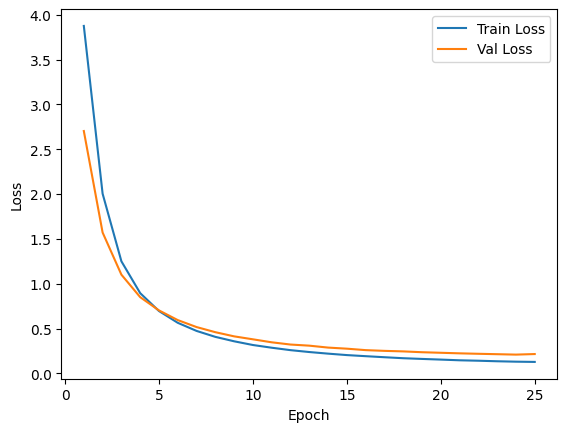

In [22]:
# Создание и обучение модели
model = LSTMClassifier(input_dim=train_embeddings.shape[1], hidden_dim=256, output_dim=len(le.classes_))

# Перемещение модели на GPU, если он доступен
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

train_losses = []
val_losses = []

n_epoches = 25

for epoch in range(n_epoches):
    train_loss = 0
    val_loss = 0
    # Обучение
    model.train()
    for texts, labels in tqdm(train_loader):
        # Перемещение данных на тот же устройство, что и модель
        texts = texts.float().to(device)
        labels = labels.to(device)

        outputs = model(texts)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    # Валидация
    model.eval()
    with torch.no_grad():
        for texts, labels in tqdm(test_loader):
            texts = texts.float().to(device)
            labels = labels.to(device)

            outputs = model(texts)
            loss = criterion(outputs, labels)

            val_loss += loss.item()

    train_loss /= len(train_loader)
    val_loss /= len(test_loader)
    train_losses.append(train_loss)
    val_losses.append(val_loss)

    print(f'Epoch {epoch+1}, Train Loss: {train_loss}, Val Loss: {val_loss}')

# Построение графика потерь
plt.plot(range(1, n_epoches + 1), train_losses, label='Train Loss')
plt.plot(range(1, n_epoches + 1), val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [23]:
# # Прогнозирование на тестовом наборе
# predictions = []
# with torch.no_grad():
#     for i, (input_ids, labels) in enumerate(test_loader):
#         input_ids = input_ids.float().to(device)

#         outputs = model(input_ids)
#         _, predicted = torch.max(outputs.data, 1)
#         predictions.extend(predicted.cpu().numpy())

# # Перевод меток обратно в исходные интенты
# predicted_intents = le.inverse_transform(predictions)

In [24]:
# Прогнозирование на тестовом наборе
predictions = []
start_test = timeit.default_timer()
with torch.no_grad():
    for i, (input_ids, labels) in enumerate(test_loader):
        input_ids = input_ids.float().to(device)

        outputs = model(input_ids)
        _, predicted = torch.max(outputs.data, 1)
        predictions.extend(predicted.cpu().numpy())
end_test = timeit.default_timer()

# Перевод меток обратно в исходные интенты
predicted_intents = le.inverse_transform(predictions)

# Общее количество предсказанных ответов
num_predictions = len(predictions)

# Среднее время на один ответ
average_time_per_response = (end_test - start_test) / num_predictions

print(f'Time for testing: {end_test - start_test:.4f} seconds')
print(f'Average time per response: {average_time_per_response:.6f} seconds')
print("precision_recall_fscore weighted", precision_recall_fscore_support(test['intent'], predicted_intents, average='weighted'))
print("balanced_accuracy", balanced_accuracy_score(test['intent'], predicted_intents))

Time for testing: 0.0687 seconds
Average time per response: 0.000024 seconds
precision_recall_fscore weighted (0.927795605762773, 0.926673751328374, 0.9250378113614393, None)
balanced_accuracy 0.9189789016355171


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [25]:
# print("precision_recall_fscore weighted", precision_recall_fscore_support(test['intent'], predicted_intents, average='weighted'))
# print("balanced_accuracy", balanced_accuracy_score(test['intent'], predicted_intents))

In [26]:
# Сохранение входных данных, истинных меток и предсказаний в DataFrame
results_df = pd.DataFrame({
    'Input': test['text'],
    'True Label': test['intent'],
    'Predicted Label': predicted_intents
})

# Сохранение DataFrame в CSV файл
results_df.to_csv('model_predictions.csv', index=False)

# Вывод первых нескольких строк для проверки
print(results_df.head())
print(results_df[results_df['True Label']!=results_df['Predicted Label']])

                                                 Input  \
8079              распологается где расписание занятий   
4950                      усваивать семинарист сколько   
9941                            где есть экзамен число   
600   как мне заказать разрешение на внос оборудования   
1121                               где есть деканат эф   

                   True Label          Predicted Label  
8079           sched_location           sched_location  
4950   stat_numb_of_academics   stat_numb_of_academics  
9941               sched_exam               sched_exam  
600   student_union_equipment  student_union_equipment  
1121              loc_dean_ef              loc_dean_ef  
                                                  Input  \
2342                   институт электрометрии раскопать   
2662                      пройти институт электрометрии   
5597                                   неважно обедать?   
2150  институт автоматики и электрометрии со ран рас...   
2444          

M-USE

In [27]:
# Load tokenizer and model
tokenizer = AutoTokenizer.from_pretrained("sadakmed/distiluse-base-multilingual-cased-v2")
model = AutoModel.from_pretrained("sadakmed/distiluse-base-multilingual-cased-v2")

tokenizer_config.json:   0%|          | 0.00/584 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/609 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/539M [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


In [28]:
# Tokenize and encode the text data
train_encodings = tokenizer(train['text'].tolist(), truncation=True, padding=True, return_tensors="pt")
test_encodings = tokenizer(test['text'].tolist(), truncation=True, padding=True, return_tensors="pt")

# Извлечение эмбеддингов
with torch.no_grad():
    train_embeddings = model(**train_encodings).last_hidden_state.mean(dim=1)
    test_embeddings = model(**test_encodings).last_hidden_state.mean(dim=1)

le = LabelEncoder()

# Преобразование меток в числовые значения
train_labels = le.fit_transform(train['intent'])
test_labels = le.transform(test['intent'])


# Преобразование массивов numpy в тензоры PyTorch перед передачей в TextDataset
train_dataset = TextDataset(train_embeddings, torch.tensor(train_labels))
test_dataset = TextDataset(test_embeddings, torch.tensor(test_labels))

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)

In [29]:
# Создание и обучение модели
model = LSTMClassifier(input_dim=train_embeddings.shape[1], hidden_dim=256, output_dim=len(le.classes_))

# Перемещение модели на GPU, если он доступен
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

train_losses = []
val_losses = []

n_epoches = 25

In [30]:
for epoch in range(n_epoches):
    train_loss = 0
    val_loss = 0
    # Обучение
    model.train()
    for texts, labels in tqdm(train_loader):
        # Перемещение данных на тот же устройство, что и модель
        texts = texts.float().to(device)
        labels = labels.to(device)

        outputs = model(texts)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    # Валидация
    model.eval()
    with torch.no_grad():
        for texts, labels in tqdm(test_loader):
            texts = texts.float().to(device)
            labels = labels.to(device)

            outputs = model(texts)
            loss = criterion(outputs, labels)

            val_loss += loss.item()

    train_loss /= len(train_loader)
    val_loss /= len(test_loader)
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    print(f'Epoch {epoch+1}, Train Loss: {train_loss}, Val Loss: {val_loss}')

100%|██████████| 89/89 [00:00<00:00, 1270.63it/s]


Epoch 1, Train Loss: 2.5643162737487057, Val Loss: 1.0246630913755868


100%|██████████| 89/89 [00:00<00:00, 1203.79it/s]


Epoch 2, Train Loss: 0.6053385955753813, Val Loss: 0.4131404251864787


100%|██████████| 89/89 [00:00<00:00, 1256.48it/s]


Epoch 3, Train Loss: 0.29551342716466944, Val Loss: 0.25680281313952436


100%|██████████| 89/89 [00:00<00:00, 1206.62it/s]


Epoch 4, Train Loss: 0.1981277626862607, Val Loss: 0.19639853049027786


100%|██████████| 89/89 [00:00<00:00, 1261.87it/s]


Epoch 5, Train Loss: 0.15562617667969159, Val Loss: 0.16309946222921437


100%|██████████| 89/89 [00:00<00:00, 1273.88it/s]


Epoch 6, Train Loss: 0.1342260840087707, Val Loss: 0.14591809548437595


100%|██████████| 89/89 [00:00<00:00, 1252.47it/s]


Epoch 7, Train Loss: 0.11821023360021392, Val Loss: 0.133285848716839


100%|██████████| 89/89 [00:00<00:00, 1219.41it/s]


Epoch 8, Train Loss: 0.1108682256629928, Val Loss: 0.12372539371377632


100%|██████████| 89/89 [00:00<00:00, 1256.91it/s]


Epoch 9, Train Loss: 0.10517793271041584, Val Loss: 0.12401686075112123


100%|██████████| 89/89 [00:00<00:00, 1192.01it/s]


Epoch 10, Train Loss: 0.10124606139781138, Val Loss: 0.11719324381163951


100%|██████████| 89/89 [00:00<00:00, 1254.71it/s]


Epoch 11, Train Loss: 0.09866536894243305, Val Loss: 0.1108997439170319


100%|██████████| 89/89 [00:00<00:00, 1236.08it/s]


Epoch 12, Train Loss: 0.09506160999508442, Val Loss: 0.10780794866738862


100%|██████████| 89/89 [00:00<00:00, 1224.46it/s]


Epoch 13, Train Loss: 0.09318310990942795, Val Loss: 0.11060239133697129


100%|██████████| 89/89 [00:00<00:00, 1276.95it/s]


Epoch 14, Train Loss: 0.09299855813068779, Val Loss: 0.11278423899784684


100%|██████████| 89/89 [00:00<00:00, 1212.49it/s]


Epoch 15, Train Loss: 0.09093577027661863, Val Loss: 0.11031878743257918


100%|██████████| 89/89 [00:00<00:00, 1239.20it/s]


Epoch 16, Train Loss: 0.0908793174399844, Val Loss: 0.10826093501024199


100%|██████████| 89/89 [00:00<00:00, 1229.61it/s]


Epoch 17, Train Loss: 0.09011002707495631, Val Loss: 0.11270504730643725


100%|██████████| 89/89 [00:00<00:00, 1172.66it/s]


Epoch 18, Train Loss: 0.08895653329206572, Val Loss: 0.10563796666958317


100%|██████████| 89/89 [00:00<00:00, 1239.35it/s]


Epoch 19, Train Loss: 0.08764835582269756, Val Loss: 0.10780393894437408


100%|██████████| 89/89 [00:00<00:00, 1261.04it/s]


Epoch 20, Train Loss: 0.08791462325562906, Val Loss: 0.10494587033021714


100%|██████████| 89/89 [00:00<00:00, 1250.99it/s]


Epoch 21, Train Loss: 0.08797649857086834, Val Loss: 0.10977409545559792


100%|██████████| 89/89 [00:00<00:00, 1253.41it/s]


Epoch 22, Train Loss: 0.0884935501395664, Val Loss: 0.10415805282275287


100%|██████████| 89/89 [00:00<00:00, 1265.82it/s]


Epoch 23, Train Loss: 0.08641769608140398, Val Loss: 0.1070748906447866


100%|██████████| 89/89 [00:00<00:00, 1231.62it/s]


Epoch 24, Train Loss: 0.08732675537857802, Val Loss: 0.1045144593213643


100%|██████████| 89/89 [00:00<00:00, 1117.99it/s]

Epoch 25, Train Loss: 0.08581404809952317, Val Loss: 0.10552603205511597


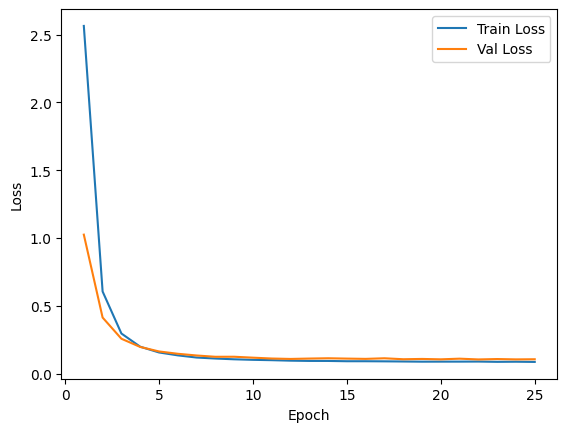

In [31]:
# Построение графика потерь
plt.plot(range(1, n_epoches + 1), train_losses, label='Train Loss')
plt.plot(range(1, n_epoches + 1), val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [32]:
# # Прогнозирование на тестовом наборе
# predictions = []
# with torch.no_grad():
#     for i, (input_ids, labels) in enumerate(test_loader):
#         input_ids = input_ids.float().to(device)

#         outputs = model(input_ids)
#         _, predicted = torch.max(outputs.data, 1)
#         predictions.extend(predicted.cpu().numpy())

# # Перевод меток обратно в исходные интенты
# predicted_intents = le.inverse_transform(predictions)

# print("precision_recall_fscore weighted", precision_recall_fscore_support(test['intent'], predicted_intents, average='weighted'))
# print("balanced_accuracy", balanced_accuracy_score(test['intent'], predicted_intents))

In [33]:
# Прогнозирование на тестовом наборе
predictions = []
start_test = timeit.default_timer()
with torch.no_grad():
    for i, (input_ids, labels) in enumerate(test_loader):
        input_ids = input_ids.float().to(device)

        outputs = model(input_ids)
        _, predicted = torch.max(outputs.data, 1)
        predictions.extend(predicted.cpu().numpy())
end_test = timeit.default_timer()

# Перевод меток обратно в исходные интенты
predicted_intents = le.inverse_transform(predictions)

# Общее количество предсказанных ответов
num_predictions = len(predictions)

# Среднее время на один ответ
average_time_per_response = (end_test - start_test) / num_predictions

print(f'Time for testing: {end_test - start_test:.4f} seconds')
print(f'Average time per response: {average_time_per_response:.6f} seconds')
print("precision_recall_fscore weighted", precision_recall_fscore_support(test['intent'], predicted_intents, average='weighted'))
print("balanced_accuracy", balanced_accuracy_score(test['intent'], predicted_intents))

Time for testing: 0.0719 seconds
Average time per response: 0.000025 seconds
precision_recall_fscore weighted (0.9529650058089093, 0.9543039319872476, 0.9527744654837481, None)
balanced_accuracy 0.9564665439044064


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [34]:
# Сохранение входных данных, истинных меток и предсказаний в DataFrame
results_df = pd.DataFrame({
    'Input': test['text'],
    'True Label': test['intent'],
    'Predicted Label': predicted_intents
})

# Сохранение DataFrame в CSV файл
results_df.to_csv('model_predictions.csv', index=False)

# Вывод первых нескольких строк для проверки
print(results_df.head())
print(results_df[results_df['True Label']!=results_df['Predicted Label']])

                                                 Input  \
8079              распологается где расписание занятий   
4950                      усваивать семинарист сколько   
9941                            где есть экзамен число   
600   как мне заказать разрешение на внос оборудования   
1121                               где есть деканат эф   

                   True Label          Predicted Label  
8079           sched_location           sched_location  
4950   stat_numb_of_academics   stat_numb_of_academics  
9941               sched_exam               sched_exam  
600   student_union_equipment  student_union_equipment  
1121              loc_dean_ef              loc_dean_ef  
                                                  Input  \
2662                      пройти институт электрометрии   
2444              расположен где институт электрометрии   
2495                  институт электрометрии обнаружить   
7720                        заказать справка о обучении   
2473          